In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='divi96',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\ASUS\Downloads\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '').replace('-', '').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'{col} {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO {table_name} ({', '.join(['' + col + '' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product_category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db  =  mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'divi96',
                             database = "ecommerce")
cur = db.cursor()
                             
                                        

# List all unique cities where customers are located

In [13]:
query = """ select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [7]:
query = """ select count(order_id) as Total_Orders from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"Total orders placed in 2017: ",data[0][0] 

('Total orders placed in 2017: ', 45101)

# Find the total sales per category

In [9]:
query = """ select products.product_category,sum(payments.payment_value) from products join order_items on 
products.product_id = order_items.product_id join payments on payments.order_id = order_items.order_id 
group by product_category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Category','Total_Sales'])
df

,Category,Total_Sales
0,perfumery,4053909.28
1,Furniture Decoration,11441411.12
2,telephony,3895056.40
3,bed table bath,13700429.36
4,automotive,6818354.64
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


# Calculate the percentage of orders that were paid in installments

In [13]:
query = """ select (sum(case when payment_installments > 1 then 1 else 0 end)/count(*) * 100 )from payments """
cur.execute(query)
data = cur.fetchall()
"Percentage of orders paid in installments: ",data[0][0] 

('Percentage of orders paid in installments: ', Decimal('49.4176'))

# Count the number of customers from each state

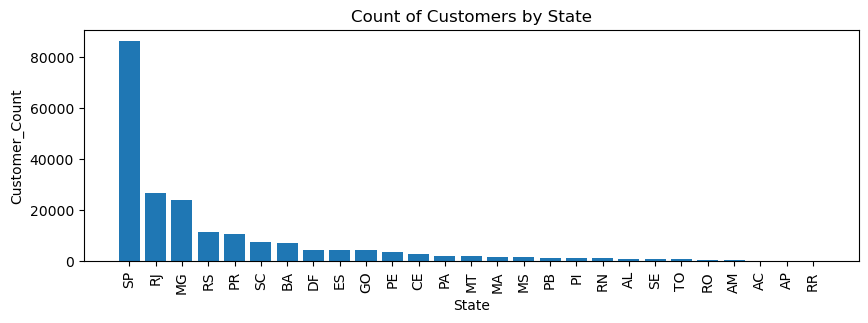

In [8]:
query = """ select customer_State , count(customer_id) as Number_of_customers from customers group by customer_state """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["State","Customer_Count"])
df = df.sort_values(by = "Customer_Count",ascending = False)
plt.figure(figsize = (10,3))
plt.bar(df["State"],df["Customer_Count"])
plt.xlabel("State")
plt.xticks(rotation = 90)
plt.ylabel("Customer_Count")
plt.title("Count of Customers by State")
plt.show()

# Calculate the number of orders per month in 2018

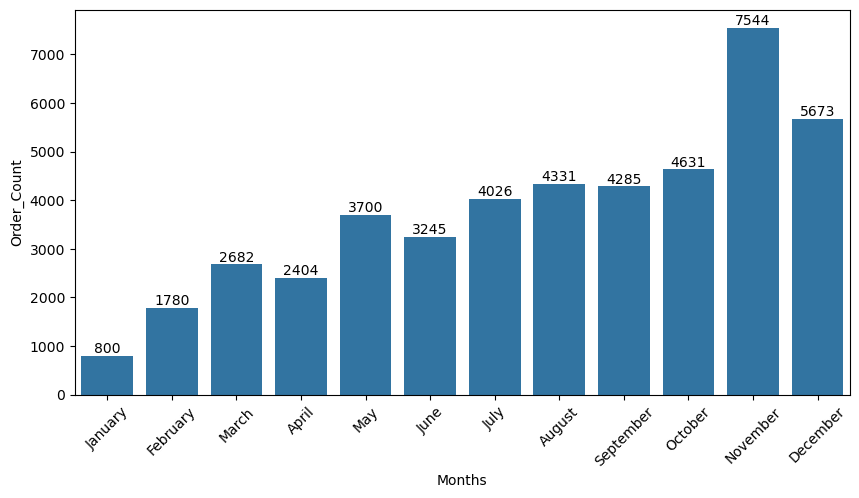

In [121]:
query = """ select monthname(order_purchase_timestamp),count(order_id) as Total_Orders from orders where year(order_purchase_timestamp) = 2017 
group by monthname(order_purchase_timestamp)"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Months','Order_Count'])
df = df.sort_values(by = 'Order_Count',ascending = False)
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
plt.figure(figsize = (10,5))
ax = sns.barplot(x = "Months", y = "Order_Count", data = df,order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

## From the above graph we can see that November month has highest number of orders and january month has least number of orders

# Find the average number of products per order, grouped by customer city

In [5]:
query="""with count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id)
as oc
from orders join order_items
on
orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)
 
select customers.customer_city,round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city 
order by average_orders desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer_City","Average_Products_Per_Order"])
df

,Customer_City,Average_Products_Per_Order
0,padre carvalho,42.00
1,celso ramos,39.00
2,datas,36.00
3,candido godoi,36.00
4,matias olimpio,30.00
...,...,...
4105,tuiuti,6.00
4106,tibau do sul,6.00
4107,sao mamede,6.00
4108,sambaiba,6.00


## From the above graph we can see that average products per order based on customer city ranges between 42 to 6

# Calculate the percentage of total revenue contributed by each product category

In [6]:

query = """select p.product_category,Round(sum(oi.price)*100/(select sum(price) from order_items),2) as Revenue_Percentage 
from products p join order_items oi 
on p.product_id = oi.product_id group by product_category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Product_Category","Revenue_Percentage"])
df = df.sort_values(by = "Revenue_Percentage",ascending = False)
df


,Product_Category,Revenue_Percentage
0,HEALTH BEAUTY,18.52
4,Watches present,17.73
8,bed table bath,15.26
1,sport leisure,14.54
3,computer accessories,13.42
...,...,...
61,PC Gamer,0.02
64,Fashion Children's Clothing,0.01
72,House Comfort 2,0.01
73,cds music dvds,0.01


## From the above graph we can see that Health beauty,Watches Present,Bed Table Bath are the top selling product category

# Identify the correlation between product price and the number of times a product has been purchased

In [6]:
query = """select p.product_category, oi.product_id, oi.price, count(oi.order_id) as order_count
from order_items oi
join products p on oi.product_id = p.product_id
group by p.product_category, oi.product_id, oi.price
order by oi.price desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Product_Category","Product_ID","Price","Purchase_Count"])
correlation = df[["Price","Purchase_Count"]].corr()
print("Correlation between Product Price and number of times a product has been purchased is:")
print(correlation)




Correlation between Product Price and number of times a product has been purchased is:
                  Price  Purchase_Count
Price           1.00000        -0.04422
Purchase_Count -0.04422         1.00000


# Calculate the total revenue generated by each seller, and rank them by revenue

In [7]:
query = """ select seller_id,round(sum(price),2) as Total_Revenue,dense_rank() over (order by sum(price) desc) as Rank_Of_Seller 
from order_items group by seller_id """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Seller_ID","Total_Revenue","Rank"])
df

,Seller_ID,Total_Revenue,Rank
0,4869f7a5dfa277a7dca6462dcf3b52b2,458945.26,1
1,53243585a1d6dc2643021fd1853d8905,445552.10,2
2,4a3ca9315b744ce9f8e9374361493884,400945.84,3
3,fa1c13f2614d7b5c4749cbc52fecda94,388084.06,4
4,7c67e1448b00f6e969d365cea6b010ab,375847.78,5
...,...,...,...
3090,34aefe746cd81b7f3b23253ea28bef39,16.00,2787
3091,702835e4b785b67a084280efca355756,15.20,2788
3092,1fa2d3def6adfa70e58c276bb64fe5bb,13.80,2789
3093,77128dec4bec4878c37ab7d6169d6f26,13.00,2790


# Calculate the moving average of order values for each customer over their order history

In [10]:
query = """select customer_id,order_date,payment,round(avg(payment) over(partition by customer_id order by order_date
rows between 2 preceding  and current row),2) as mov_avg from
(select o.customer_id,date(min(cast(o.order_purchase_timestamp as datetime))) as order_date,round(sum(p.payment_value),2) as payment 
from orders o join payments p 
on o.order_id = p.order_id group by o.customer_id,o.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer_Id","Order_Date","Total_Amount","Moving_Average"])
df


,Customer_Id,Order_Date,Total_Amount,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14,688.44,688.44
1,000161a058600d5901f007fab4c27140,2017-07-16,404.46,404.46
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28,1172.52,1172.52
3,0002414f95344307404f0ace7a26f1d5,2017-08-16,1076.10,1076.10
4,000379cdec625522490c315e70c7a9fb,2018-04-02,642.06,642.06
...,...,...,...,...
99435,fffecc9f79fd8c764f843e9951b11341,2018-03-29,488.16,488.16
99436,fffeda5b6d849fbd39689bb92087f431,2018-05-22,378.78,378.78
99437,ffff42319e9b2d713724ae527742af25,2018-06-13,1284.78,1284.78
99438,ffffa3172527f765de70084a7e53aae8,2017-09-02,273.00,273.00


# Calculate the cumulative sales per month for each year

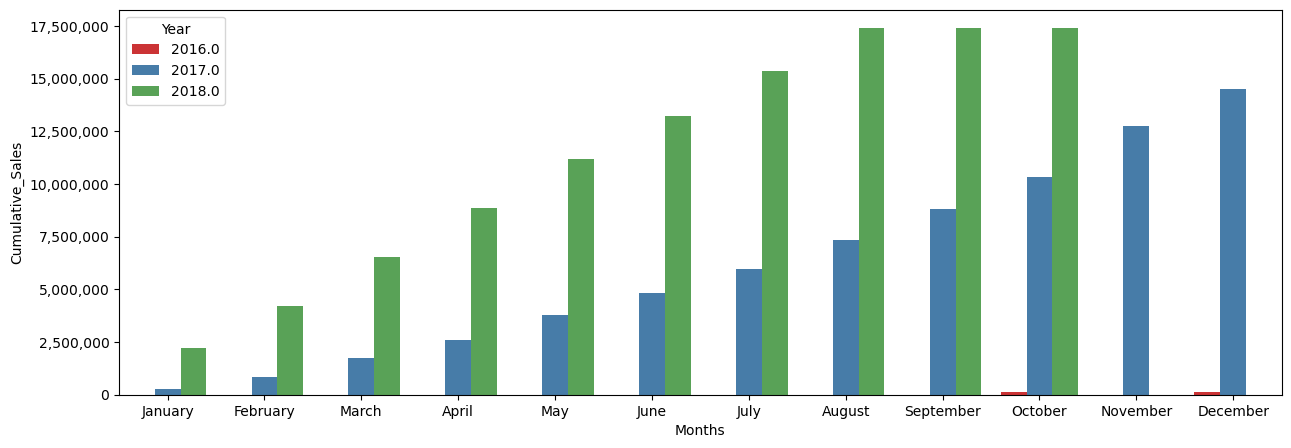

In [35]:
query = """select years,months,payment,round(sum(payment) over (partition by years order by years,month_num),2) as cumulative_sales_per_month from
(select year(o.order_purchase_timestamp) as years,month(o.order_purchase_timestamp) as month_num,
monthname(o.order_purchase_timestamp) 
as months,round(sum(p.payment_value),2) as payment 
from orders o join payments p on o.order_id = p.order_id group by years,month_num,months) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Years","Months","Total_Sales","Cumulative_Sales"])
month_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
plt.figure(figsize = (15,5))
ax = sns.barplot(x = "Months", y = "Cumulative_Sales", data = df,hue = "Years",order = month_order,palette = "Set1")
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.legend(title="Year")
plt.show()



## Based on the chart,Sales grew steadily from 2017 and reached their highest point in 2018

# Calculate the year-over-year growth rate of total sales

In [38]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years,round(sum(payments.payment_value),2) as payment
from payments join orders on orders.order_id=payments.order_id group by years order by years)
select years, round(((payment-lag(payment,1) over(order by years))/lag(payment,1) over (order by years))*100,2) as yoy_growth_percentage 
from a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Years","YOY_Growth_Percentage"])
df

,Years,YOY_Growth_Percentage
0,NaN,NaN
1,2016.0,-99.81
2,2017.0,12112.70
3,2018.0,20.00


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [43]:
query = """ with a as(select customers.customer_id,min(orders.order_purchase_timestamp) first_order
from customers join orders on customers.customer_id=orders.customer_id
group by customers.customer_id),
 
b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp>first_order
and orders.order_purchase_timestamp <date_add(first_order,interval 6 month)
group by a.customer_id)
select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id)) as retention_rate
from a left join b on
a.customer_id=b.customer_id """
cur.execute(query)
data = cur.fetchall()
"Retention Rate of Customers is:", data[0][0]


('Retention Rate of Customers is:', None)

## The data shows that no customers made a repeat purchase within six months of their first order.

# Identify the top 3 customers who spent the most money in each year

In [44]:
query = """ select c.customer_id,round(sum(p.payment_value),2) as Total_Revenue from customers c join orders o 
on c.customer_id = o.customer_id join payments p on
p.order_id = o.order_id group by c.customer_id order by Total_Revenue desc limit 3 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer_ID","Total_Revenue"])
df

,Customer_ID,Total_Revenue
0,1617b1357756262bfa56ab541c47bc16,245953.44
1,3fd6777bbce08a352fddd04e4a7cc8f6,121079.88
2,ec5b2ba62e574342386871631fafd3fc,87298.56


In [16]:
df.isnull().sum

<bound method DataFrame.sum of           0
0     False
1     False
2     False
3     False
4     False
...     ...
4114  False
4115  False
4116  False
4117  False
4118  False

[4119 rows x 1 columns]>